# SentimentArcs Simplified Notebook

Created:

* 28 Oct 2022
* Jon Chun

A simplified version of SentimentArcs Notebooks with only the most common and state-of-the-art sentiment analysis models in the ensemble. This operationalizes SentimentArcs more accessible and robust.

* https://github.com/jon-chun/sentimentarcs_notebooks

* https://arxiv.org/pdf/2110.09454.pdf

# **PRE-REQUISITES**

## INPUT Text File
- name: format 'book_{title-words}_{author}.txt'
-- eg book_animal-farm_gorwell.txt
-- eg book_the-great-gatsby_fscottfitzgerald.txt
- content: cleaned plain text

## API Keys Necessary
- huggingface.co ('HF_TOKEN')
- wandb.com ('WANDB_TOKEN')



# Review VM Specs

In [ ]:
# Make sure your Linux VM is connected to a GPU

!nvidia-smi

Tue Oct 29 04:55:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Node GPU Count/Type

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0ab3a41c-9bf1-303c-bbff-f62306d67ad2)


In [ ]:
# Memory

!free -h --si | awk  '/Mem:/{print $2}'

12G


In [ ]:
# GPU log information

# !nvidia-smi -q

In [ ]:
# Check how many CPU cores available for parallization

!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
ad

In [ ]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 cl
                          flush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc re
                          p_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3
                           fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand
                           hypervisor lahf_lm abm 3dnowprefetch i

# Setup

## Install Libraries

In [ ]:
# !pip install transformers[sentencepiece]

!pip install transformers

In [ ]:
# May require [RESET RUNTIME]

# !pip install modin[all]

## Import Libraries

In [ ]:
from google.colab import files

In [ ]:
import numpy as np
import pandas as pd
# import modin.pandas as pd_modin
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import re
import os

from tqdm import tqdm
import tqdm.notebook as tq
# for i in tq.tqdm(...):

## Configure Settings

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Global Variables & Functions

## Global Variables

In [ ]:
# Main (Modin) DataFrame for Novel Sentiments

sentiment_df = pd.DataFrame


## Common Functions

In [ ]:
def verify_novel(novel_str, index_ends=500):
  '''
  INPUT: string in some stage of processing
  OUTPUT: display summary index_ends chars of header/footer for verification
  '''

  print(f'Novel Name: {novel_name_str}')
  print(f'  Char Len: {len(novel_str)}')
  print('====================================\n')
  print(f'Beginning:\n\n {novel_str[:index_ends]}\n\n')
  print('\n------------------------------------')
  print(f'Ending:\n\n {novel_str[-index_ends:]}\n\n')

In [ ]:
def save_text2txt_and_download(text_obj, file_suffix='_save.txt'):
  '''
  INPUT: text object and suffix to add to output text filename
  OUTPUT: Write text object to text file (both temp VM and download)
  '''

  if type(text_obj) == str:
    print('STEP 1. Processing String Object\n')
    str_obj = text_obj
  elif type(text_obj) == list:
    if (len(text_obj) > 0):
      if type(text_obj[0]) == str:
        print('STEP 1. Processing List of Strings Object\n')
        str_obj = "\n".join(text_obj)
      else:
        print('ERROR: Object is not an List of Strings [save_text2txt_and_download()]')
        return -1
    else:
      print('ERROR: Object is an empty List [save_text2txt_and_download()]')
      return -1
  else:
    print('ERROR: Object Type is neither String nor List [save_text2txt_and_download()]')
    return -1

  datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  # out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
  out_filename = novel_name_str.split('.')[0] + file_suffix

  # Write file to temporary VM filesystem
  print(f'STEP 2. Saving textfile to temporary VM file: {out_filename}\n')
  with open(out_filename, "w") as fp:
    fp.write(str_obj)

  # Download permanent copy of file
  print(f'STEP 3. Downloading permanent copy of textfile: {out_filename}\n')
  files.download(out_filename)

In [ ]:
def save_plot2png(file_suffix='_plot.png', nodate=True):
    '''
    Save the current plot to a PNG file.

    INPUT:
    - file_suffix: The suffix to add to the output PNG filename.
    - nodate: If True, the date is not added to the filename; if False, the date is included.

    OUTPUT:
    - Saves the current plot to a PNG file in the temporary VM and downloads it.
    '''
    # Construct the filename based on whether the date should be included
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
        out_filename = novel_name_str.split('.')[0] + file_suffix
    else:
        out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix

    # Save the plot
    plt.savefig(out_filename)
    print(f'STEP 1. Saving plot to temporary VM file: {out_filename}\n')

    # Download the saved file
    print(f'STEP 2. Downloading permanent copy of the PNG file: {out_filename}\n')
    files.download(out_filename)

In [ ]:
def save_df2csv_and_download(df_obj, file_suffix='_save.csv', nodate=True):
  '''
  INPUT: DataFrame object and suffix to add to output csv filename
  OUTPUT: Write DataFrame object to csv file (both temp VM and download)
  '''

  if isinstance(df_obj, pd.DataFrame):
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    if nodate:
      out_filename = novel_name_str.split('.')[0] + file_suffix
    else:
      out_filename = novel_name_str.split('.')[0] + '_' + datetime_str + file_suffix
    # print(f'STEP 1. Saving DataFrame: {df_obj.__name__} to temporary VM file: {out_filename}\n') # Also, isinstance(obj, pd.DataFrame)
    print(f'STEP 1. Saving DataFrame to temporary VM file: {out_filename}\n')
    df_obj.to_csv(out_filename, index=False)
  else:
    print(f'ERROR: Object is not a DataFrame [save_df2csv_and_download()]')
    return -1

  # Download permanent copy of file
  print(f'STEP 2. Downloading permanent copy of csvfile: {out_filename}\n')
  files.download(out_filename)


# Test

# save_df2csv_and_download(temp_df, '_bert-nlptown.txt')

# Get Clean Text

## Upload Trimmed Gutenberg Text (no header/footer)

Get plain text of familiar novel at:
* https://gutenberg.net.au/ (AUS)
* https://gutenberg.org/ (US)

In [ ]:
# Upload Plain Text File
novel_name_str = ''
uploaded = files.upload()

# Allows for multiple file uploads, will only process the last
# Left in for future feature addition (processing multiple files at once)
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    novel_name_str = fn

# Extract from Dict and decode binary into char string
TEXT_ENCODING = 'utf-8'  # Define the encoding format
novel_raw_str = uploaded[novel_name_str].decode(TEXT_ENCODING)


KeyError: ''

In [ ]:
!ls

book_a-brave-new-world_ahuxley_segments.txt
book_frankenstein_mshelley_distilbert_sentiment.csv
book_frankenstein_mshelley_distilbert_sentiment_plot.png
book_frankenstein_mshelley_nlptown_sentiment.csv
book_frankenstein_mshelley_nlptown_sentiment_plot.png
book_frankenstein_mshelley_roberta15lg_sentiment.csv
book_frankenstein_mshelley_roberta15lg_sentiment_plot.png
book_frankenstein_mshelley_segments.txt
book_frankenstein_mshelley_sentimentr_sentiment.csv
book_frankenstein_mshelley_sentimentr_sentiment_plot.png
book_frankenstein_mshelley_syuzhetr_sentiment.csv
book_frankenstein_mshelley_syzhet_sentiment_plot.png
book_frankenstein_mshelley_textblob_sentiment.csv
book_frankenstein_mshelley_textblob_sentiment_plot.png
book_frankenstein_mshelley.txt
book_frankenstein_mshelley_vader_sentiment.csv
book_frankenstein_mshelley_vader_sentiment_plot.png
book_theodyssey_homer_distilbert_sentiment.csv
book_theodyssey_homer_distilbert_sentiment_plot.png
book_theodyssey_homer_nlptown_sentiment.csv
boo

In [ ]:
# Verify

verify_novel(novel_raw_str)

Novel Name: book_a-brave-new-world_ahuxley_segments.txt
  Char Len: 377436

Beginning:

 chapter i a squat grey building of only thirty-four stories.
over the main entrance the words, =central london hatchery and conditioning centre=, and, in a shield, the world state's motto, =community, identity, stability=.
the enormous room on the ground-floor faced towards the north.
cold for all the summer beyond the panes, for all the tropical heat of the room itself, a harsh thin light glared through the windows, hungrily seeking some draped lay figure, some pallid shape of academic goose-fl



------------------------------------
Ending:

  a few seconds, turned as unhurriedly back towards the left.
south-southwest, south, south-east, east . . . printed in great britain by t.
and a.
constable ltd. at the university press edinburgh transcriber notes misspelled words and printer errors have been corrected.
where multiple spellings occur, majority use has been employed.
punctuation has been maint

## Clean Text

In [ ]:
!pip install clean-text

In [ ]:
!pip install unidecode  # clean-text dependency

In [ ]:
from cleantext import clean

In [ ]:
novel_clean_str = clean(novel_raw_str,
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=False,                  # replace all URLs with a special token
    no_emails=False,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    # replace_with_punct="",          # instead of removing punctuations you may replace them
    # replace_with_url="<URL>",
    # replace_with_email="<EMAIL>",
    # replace_with_phone_number="<PHONE>",
    # replace_with_number="<NUMBER>",
    # replace_with_digit="0",
    # replace_with_currency_symbol="<CUR>",
    lang="en"                       # set to 'de' for German special handling
)

# Replace all new lines/returns with single whitespace
novel_clean_str = novel_clean_str.replace('\n\r', ' ')
novel_clean_str = novel_clean_str.replace('\n', ' ')
novel_clean_str = novel_clean_str.replace('\r', ' ')
novel_clean_str = ' '.join(novel_clean_str.split())
novel_clean_str

'tell me, muse, of that man, so ready at need, who wandered far and wide, after he had sacked the sacred citadel of troy, and many were the men whose towns he saw and whose mind he learnt, yea, and many the woes he suffered in his heart on the deep, striving to win his own life and the return of his company. nay, but even so he saved not his company, though he desired it sore. for through the blindness of their own hearts they perished, fools, who devoured the oxen of helios hyperion: but the god took from them their day of returning. of these things, goddess, daughter of zeus, whencesoever thou hast heard thereof, declare thou even unto us. now all the rest, as many as fled from sheer destruction, were at home, and had escaped both war and sea, but odysseus only, craving for his wife and for his homeward path, the lady nymph calypso held, that fair goddess, in her hollow caves, longing to have him for her lord. but when now the year had come in the courses of the seasons, wherein the 

In [ ]:
# Verify

verify_novel(novel_clean_str, index_ends=500)

Novel Name: book_theodyssey_homer.txt
  Char Len: 621905

Beginning:

 tell me, muse, of that man, so ready at need, who wandered far and wide, after he had sacked the sacred citadel of troy, and many were the men whose towns he saw and whose mind he learnt, yea, and many the woes he suffered in his heart on the deep, striving to win his own life and the return of his company. nay, but even so he saved not his company, though he desired it sore. for through the blindness of their own hearts they perished, fools, who devoured the oxen of helios hyperion: but the god



------------------------------------
Ending:

 o the city for their lives. but ulysses gave a great cry, and gathering himself together swooped down like a soaring eagle. then the son of saturn sent a thunderbolt of fire that fell just in front of minerva, so she said to ulysses, "ulysses, noble son of laertes, stop this warful strife, or jove will be angry with you." thus spoke minerva, and ulysses obeyed her gladly. the

## Trim Text

In [ ]:
# FUTURE: Auto trim Gutenberg HEADER and FOOTER (varies too much)

novel_trim_str = novel_clean_str

## Segment Text

In [ ]:
!pip install pysbd  # Python Sentence Boundry Detection

In [ ]:
import pysbd

In [ ]:
# FIX: Normally assigned within the 'Trim Header & Footer' Section

# Ensure we have trimmed version of novel in novel_trim_str

if len(novel_trim_str) > 0:
  # Header/Footer already trimmed from body of Novel
  pass
else:
  novel_trim_str = novel_raw_str

In [ ]:
!ls -altr | tail

-rw-r--r-- 1 root root 202617 Oct 30 21:27 book_theodyssey_homer_sentimentr_sentiment_plot.png
-rw-r--r-- 1 root root 500089 Oct 30 21:27 book_theodyssey_homer_sentimentr_sentiment.csv
-rw-r--r-- 1 root root  41399 Oct 30 21:28 book_theodyssey_homer_distilbert_sentiment_plot.png
-rw-r--r-- 1 root root 656335 Oct 30 21:28 book_theodyssey_homer_distilbert_sentiment.csv
-rw-r--r-- 1 root root  42665 Oct 30 21:29 book_theodyssey_homer_nlptown_sentiment_plot.png
-rw-r--r-- 1 root root 655286 Oct 30 21:29 book_theodyssey_homer_nlptown_sentiment.csv
-rw-r--r-- 1 root root  40962 Oct 30 21:31 book_theodyssey_homer_roberta15lg_sentiment_plot.png
-rw-r--r-- 1 root root 656369 Oct 30 21:31 book_theodyssey_homer_roberta15lg_sentiment.csv
-rw-r--r-- 1 root root 377436 Oct 30 21:33 book_a-brave-new-world_ahuxley_segments.txt
drwxr-xr-x 1 root root   4096 Oct 30 21:33 .


In [ ]:
%%time

# OPTION A: Segment book string

# NOTE:  1m05s animal farm
#       11m22s harry potter
#        2m13s jane eyre

# Split Novel into Segments (~Sentences)
seg = pysbd.Segmenter(language="en", clean=False)
# novel_segments_ls = seg.segment(novel_trim_str)
novel_segments_ls = [segment for segment in tqdm(seg.segment(novel_trim_str), desc="Segmenting Novel")]

Segmenting Novel: 100%|██████████| 1191/1191 [00:00<00:00, 681781.91it/s]

CPU times: user 5min 5s, sys: 894 ms, total: 5min 6s
Wall time: 5min 28s


In [ ]:
# OPTION B: Read in segmented text file

# prompt: read a filename and save input lines as strings in list novel_segments_ls

"""
novel_name_str = 'book_a-brave-new-world_ahuxley_segments.txt'


novel_segments_ls = []
with open(novel_name_str, 'r') as f:
  for line in f:
    novel_segments_ls.append(line.strip())
""";

In [ ]:
# Trim any leading/trailing whitespace on all Sentences

novel_clean_ls = [x.strip() for x in novel_segments_ls]

In [ ]:
# Verify

verify_novel(novel_clean_ls, 10)

Novel Name: book_a-brave-new-world_ahuxley_segments.txt
  Char Len: 2723

Beginning:

 ['chapter i a squat grey building of only thirty-four stories.', "over the main entrance the words, =central london hatchery and conditioning centre=, and, in a shield, the world state's motto, =community, identity, stability=.", 'the enormous room on the ground-floor faced towards the north.', 'cold for all the summer beyond the panes, for all the tropical heat of the room itself, a harsh thin light glared through the windows, hungrily seeking some draped lay figure, some pallid shape of academic goose-flesh, but finding only the glass and nickel and bleakly shining porcelain of a laboratory.', 'wintriness responded to wintriness.', 'the overalls of the workers were white, their hands gloved with a pale corpse-coloured rubber.', 'the light was frozen, dead, a ghost.', 'only from the yellow barrels of the microscopes did it borrow a certain rich and living substance, lying along the polished tubes li

In [ ]:
# Save to file and download copy

save_text2txt_and_download(novel_clean_ls, '_segments.txt')

STEP 1. Processing List of Strings Object

STEP 2. Saving textfile to temporary VM file: book_a-brave-new-world_ahuxley_segments_segments.txt

STEP 3. Downloading permanent copy of textfile: book_a-brave-new-world_ahuxley_segments_segments.txt



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sentiment_df

,line_no,line
0,0,"tell me, muse, of that man, so ready at need, ..."
1,1,"nay, but even so he saved not his company, tho..."
2,2,for through the blindness of their own hearts ...
3,3,"of these things, goddess, daughter of zeus, wh..."
4,4,"now all the rest, as many as fled from sheer d..."
...,...,...
1186,1186,meantime ulysses and his son fell upon the fro...
1187,1187,"""men of ithaca,"" she cried, ""cease this dreadf..."
1188,1188,"but ulysses gave a great cry, and gathering hi..."
1189,1189,then the son of saturn sent a thunderbolt of f...


In [ ]:
# Populate novel sentiment_df with sentence number and clean segmented strings

sentence_no_ls = list(range(len(novel_clean_ls)))
sentence_no_ls[-1]

sentiment_df = pd.DataFrame({'line_no':sentence_no_ls, 'line':novel_clean_ls})
sentiment_df.head()

2722

,line_no,line
0,0,chapter i a squat grey building of only thirty...
1,1,"over the main entrance the words, =central lon..."
2,2,the enormous room on the ground-floor faced to...
3,3,"cold for all the summer beyond the panes, for ..."
4,4,wintriness responded to wintriness.


# Compute Sentiment

## Option (1): Symbolic: Lexicons

### VADER

In [ ]:
!pip install vaderSentiment

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sid_obj = SentimentIntensityAnalyzer()

In [ ]:
sentiment_vader_ls = [sid_obj.polarity_scores(asentence)['compound'] for asentence in novel_clean_ls]

In [ ]:
# Create new VADER DataFrame to save results

vader_df = sentiment_df[['line_no', 'line']].copy(deep=True)
vader_df['sentiment'] = pd.Series(sentiment_vader_ls)
vader_df.head()

,line_no,line,sentiment
0,0,chapter i a squat grey building of only thirty...,0.0516
1,1,"over the main entrance the words, =central lon...",0.0000
2,2,the enormous room on the ground-floor faced to...,0.0000
3,3,"cold for all the summer beyond the panes, for ...",-0.2382
4,4,wintriness responded to wintriness.,0.0000


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'VADER Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_a-brave-new-world_ahuxley_segments_vader_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_a-brave-new-world_ahuxley_segments_vader_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

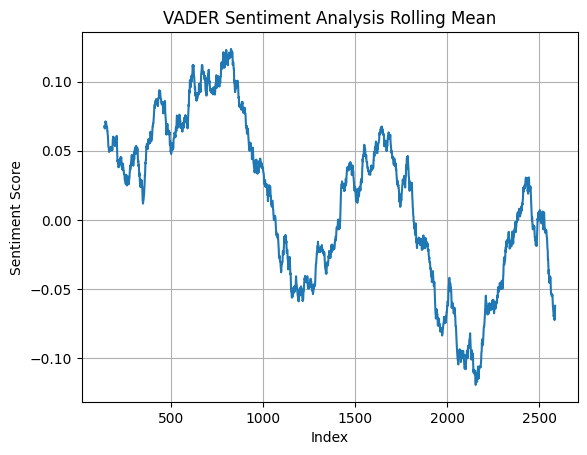

In [ ]:
win_per = 0.1
win_size = int(win_per * vader_df.shape[0])

# Create a new figure
plt.figure()

_ = vader_df['sentiment'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("VADER Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_vader_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [ ]:
# Save VADER Model Sentiment Time Series

save_df2csv_and_download(vader_df, '_vader_sentiment.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: book_a-brave-new-world_ahuxley_segments_vader_sentiment.csv

STEP 2. Downloading permanent copy of csvfile: book_a-brave-new-world_ahuxley_segments_vader_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **TextBlob**

In [ ]:
from textblob import TextBlob

In [ ]:
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
print(testimonial.sentiment.polarity)

0.39166666666666666


In [ ]:
sentiment_textblob_ls = [TextBlob(asentence).sentiment.polarity for asentence in novel_clean_ls]
# sentiment_df['textblob'] = sentiment_df['text_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)

In [ ]:
# Create new TextBlob DataFrame to save results

textblob_df = sentiment_df[['line_no', 'line']].copy(deep=True)
textblob_df['sentiment'] = pd.Series(sentiment_textblob_ls)
textblob_df.head()

,line_no,line,sentiment
0,0,chapter i a squat grey building of only thirty...,-0.025000
1,1,"over the main entrance the words, =central lon...",0.083333
2,2,the enormous room on the ground-floor faced to...,0.000000
3,3,"cold for all the summer beyond the panes, for ...",-0.257143
4,4,wintriness responded to wintriness.,0.000000


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'TextBlob Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_a-brave-new-world_ahuxley_segments_textblob_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_a-brave-new-world_ahuxley_segments_textblob_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

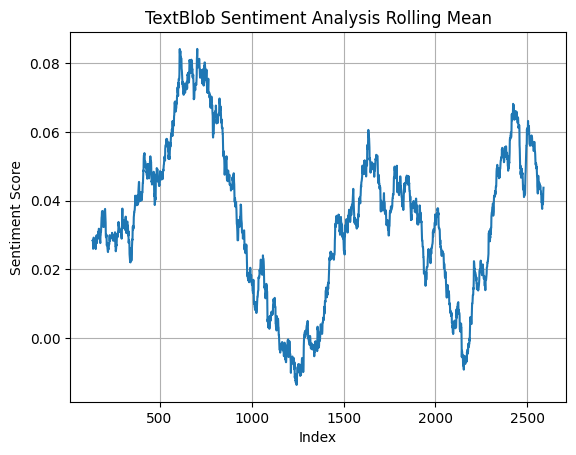

In [ ]:
win_per = 0.1
win_size = int(win_per * textblob_df.shape[0])

# Create a new figure
plt.figure()

_ = textblob_df['sentiment'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("TextBlob Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_textblob_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [ ]:
# Save TextBlob Model Sentiment Time Series

save_df2csv_and_download(textblob_df, '_textblob_sentiment.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: book_a-brave-new-world_ahuxley_segments_textblob_sentiment.csv

STEP 2. Downloading permanent copy of csvfile: book_a-brave-new-world_ahuxley_segments_textblob_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### SyuzhetR (4)

* SyzuhetR: https://cran.r-project.org/web/packages/readtext/vignettes/readtext_vignette.html
* http://rstudio-pubs-static.s3.amazonaws.com/283881_efbb666d653a4eb3b0c5e5672e3446c6.html

* SentimentR: https://github.com/trinker/sentimentr

* JupyterLab w/Py OR R: https://www.youtube.com/watch?v=Q35WIqZoUF4

In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
# Load Python libraries to exchange data with R Program Space and read R Datafiles

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

In [ ]:
%R getwd()

'/content'


In [ ]:
%R list.files()

'book_a-b...,'book_a-b...,'book_a-b...,...,'sample_d...,'tmp_trai...,'wandb'


In [ ]:
%%time
%%capture
%%R

# Install Syuzhet.R, Sentiment.R and Utility Libraries

# NOTE: 56s 17:30EST on 27Oct2022 - Colab Pro

install.packages(c('sentimentr'))

library(sentimentr)

(as ‘lib’ is unspecified)







	‘/tmp/RtmpA0O3PG/downloaded_packages’



CPU times: user 1.05 s, sys: 41 ms, total: 1.09 s
Wall time: 15.7 s


In [ ]:
%%time
%%capture
%%R

# Install Syuzhet.R, Sentiment.R and Utility Libraries

# NOTE: 56s 17:30EST on 27Oct2022 - Colab Pro

install.packages(c('syuzhet', 'sentimentr', 'tidyverse', 'lexicon'))

library(syuzhet)
library(sentimentr)
library(tidyverse)
library(lexicon)

(as ‘lib’ is unspecified)






















	‘/tmp/RtmpA0O3PG/downloaded_packages’



CPU times: user 1.73 s, sys: 106 ms, total: 1.83 s
Wall time: 43.9 s


In [ ]:
%R sessionInfo()

<rpy2.robjects.vectors.ListVector object at 0x7dc679e01180> [RTYPES.VECSXP]
R classes: ('sessionInfo',)
[ListSexpV..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
<rpy2.robjects.vectors.ListVector object at 0x7dc679e01180> [RTYPES.VECSXP]
R classes: ('sessionInfo',)
[ListSexpV..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
  platform: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7dc679dfe380> [RTYPES.STRSXP]
R classes: ('character',)
['x86_64-pc-linux-gnu']
  locale: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7dc551e0b680> [RTYPES.STRSXP]
R classes: ('character',)
['LC_CTYPE=en_US.UTF-8;LC_NUMERIC=C;LC_TIME=en_US....]
  tzone: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7dc55099a940> [RTYPES.STRSXP]
R classes: ('character',)
['Etc/UTC']
...
  running: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7dc55013f100> [RTYPES.STRSXP]
R classes: ('character',)
['default']
  RNGkind: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7dc55013f1c0> [RTYPES.STRSXP]
R classes: ('character',)
['/usr/lib/x86_64-linux-gnu/openblas-pthread/libbl...]
  basePkgs: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7dc55013f440> [RTYPES.STRSXP]
R classes: ('character',)
['/usr/lib/x86_64-linux-gnu/openblas-pthread/libla...]
  otherPkgs: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7dc55013fd00> [RTYPES.STRSXP]
R classes: ('character',)
['3.10.0']

In [ ]:
sentiment_df.head()

,line_no,line
0,0,chapter i a squat grey building of only thirty...
1,1,"over the main entrance the words, =central lon..."
2,2,the enormous room on the ground-floor faced to...
3,3,"cold for all the summer beyond the panes, for ..."
4,4,wintriness responded to wintriness.


In [ ]:
%%time

# Compute Sentiments from all 4 Syuzhet Models

# NOTE:  3m57s 17:40EST on 27Oct2022 Colab Pro (The Idiot)
#        3m55s 18:02EST on 27Oct2022 Colab Pro (The Idiot)
#        4m10s 23:14EST on 27Oct2022 Colab Pro (The Idiot)

syuzhet = importr('syuzhet')

# Create new SyuzhetR DataFrame to save results
syuzhet_df = sentiment_df[['line_no', 'line']].copy(deep=True)

print('[1/4] Processing syuzhetr_syuzhet')
syuzhet_df['syuzhetr_syuzhet'] = syuzhet.get_sentiment(syuzhet_df['line'].to_list(), method='syuzhet')
print('[2/4] Processing syuzhetr_bing')
syuzhet_df['syuzhetr_bing'] = syuzhet.get_sentiment(syuzhet_df['line'].to_list(), method='bing')
print('[3/4] Processing syuzhetr_afinn')
syuzhet_df['syuzhetr_afinn'] = syuzhet.get_sentiment(syuzhet_df['line'].to_list(), method='afinn')
print('[4/4] Processing syuzhetr_nrc')
syuzhet_df['syuzhetr_nrc'] = syuzhet.get_sentiment(syuzhet_df['line'].to_list(), method='nrc')

syuzhet_df.head()

[1/4] Processing syuzhetr_syuzhet
[2/4] Processing syuzhetr_bing
[3/4] Processing syuzhetr_afinn
[4/4] Processing syuzhetr_nrc
CPU times: user 7.71 s, sys: 17.9 ms, total: 7.73 s
Wall time: 7.79 s


,line_no,line,syuzhetr_syuzhet,syuzhetr_bing,syuzhetr_afinn,syuzhetr_nrc
0,0,chapter i a squat grey building of only thirty...,0.1,0,-1,1.0
1,1,"over the main entrance the words, =central lon...",1.5,1,0,1.0
2,2,the enormous room on the ground-floor faced to...,0.0,0,0,0.0
3,3,"cold for all the summer beyond the panes, for ...",-2.9,-3,-2,2.0
4,4,wintriness responded to wintriness.,0.0,0,0,0.0


<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Syuzhet Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_a-brave-new-world_ahuxley_segments_syzhet_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_a-brave-new-world_ahuxley_segments_syzhet_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

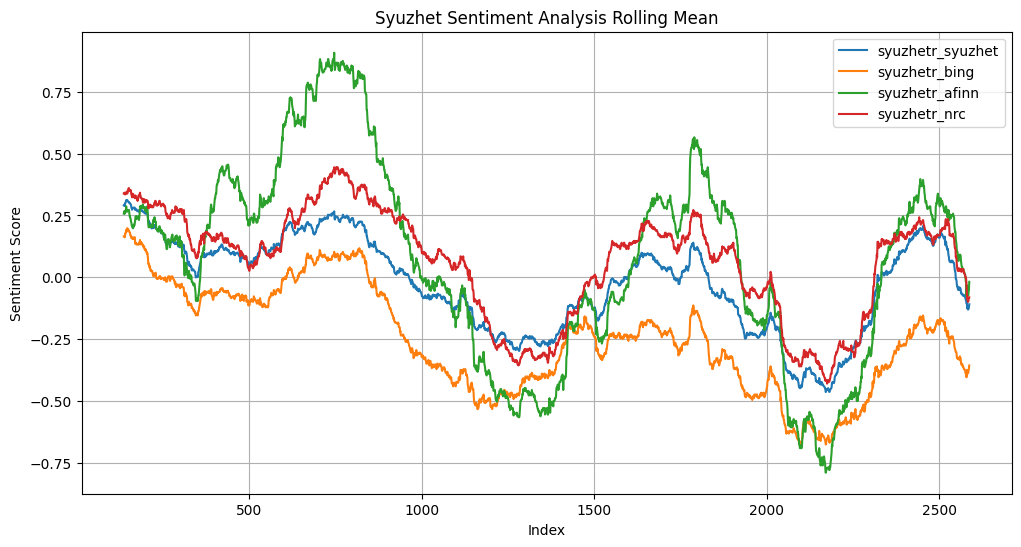

In [ ]:
# Generate the plot properly
win_per = 0.1
win_size = int(win_per * syuzhet_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean sentiment
syuzhet_model_ls = ['syuzhetr_syuzhet', 'syuzhetr_bing', 'syuzhetr_afinn', 'syuzhetr_nrc']
_ = syuzhet_df[syuzhet_model_ls].rolling(win_size, center=True).mean().plot(figsize=(12,6), grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("Syuzhet Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_syzhet_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()


In [ ]:
# Save SyuzhetR Models' Sentiment Time Series

save_df2csv_and_download(syuzhet_df, '_syuzhetr_sentiment.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: book_a-brave-new-world_ahuxley_segments_syuzhetr_sentiment.csv

STEP 2. Downloading permanent copy of csvfile: book_a-brave-new-world_ahuxley_segments_syuzhetr_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### SentimentR (8)

Call function in external get_sentimentr.R from within Python Loop

* https://medium.com/analytics-vidhya/calling-r-from-python-magic-of-rpy2-d8cbbf991571

* https://rpy2.github.io/doc/v3.0.x/html/generated_rst/pandas.html

In [ ]:
%%file get_sentimentr.R

library(sentimentr)
library(lexicon)

get_sentimentr_values <- function(s_v) {

  print('[1/8] Processing sentimentr_jockersrinker')
  sentimentr_jockersrinker <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_jockers_rinker,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[2/8] Processing sentimentr_jockers')
  sentimentr_jockers <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_jockers,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[3/8] Processing sentimentr_huliu')
  sentimentr_huliu <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_huliu,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[4/8] Processing sentimentr_nrc')
  sentimentr_nrc <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_nrc,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[5/8] Processing sentimentr_senticnet')
  sentimentr_senticnet <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_senticnet,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[6/8] Processing sentimentr_sentiword')
  sentimentr_sentiword <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_sentiword,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[7/8] Processing sentimentr_loughran_mcdonald')
  sentimentr_loughran_mcdonald <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_loughran_mcdonald,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('[8/8] Processing sentimentr_socal_google')
  sentimentr_socal_google <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_socal_google,
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  anovel_sentimentr_df <- data.frame(# 'text_clean' = s_v,
                                'sentimentr_jockersrinker' = sentimentr_jockersrinker$sentiment,
                                'sentimentr_jockers' = sentimentr_jockers$sentiment,
                                'sentimentr_huliu' = sentimentr_huliu$sentiment,
                                'sentimentr_nrc' = sentimentr_nrc$sentiment,
                                'sentimentr_senticnet' = sentimentr_senticnet$sentiment,
                                'sentimentr_sentiword' = sentimentr_sentiword$sentiment,
                                'sentimentr_loughran_mcdonald' = sentimentr_loughran_mcdonald$sentiment,
                                'sentimentr_socal_google' = sentimentr_socal_google$sentiment
                                )
  return(anovel_sentimentr_df)

}

Overwriting get_sentimentr.R


In [ ]:
# Verify the *.R file above was written correctly

# !cat get_sentimentr.R

In [ ]:
# Setup python robject with external library::function()
# https://rpy2.github.io/doc/v3.0.x/html/generated_rst/pandas.html

# import rpy2.robjects as robjects

# Defining the R script and loading the instance in Python
# from rpy2.robjects import pandas2ri
r = robjects.r

# Loading the function we have defined in R.
r['source']('get_sentimentr.R')

# Reading and processing data
get_sentimentr_function_r = robjects.globalenv['get_sentimentr_values']

value,[RTYPES.CLOSXP]
visible,[RTYPES.LGLSXP]


In [ ]:
%%time

# NOTE:   2m40s  @17:48EST on 27Oct2022 Colab Pro (The Idiot)
#         2m42s  @18:06EST on 27Oct2022 Colab Pro (The Idiot)
#         2m37s  @23:20EST on 27Oct2022 Colab Pro (The Idiot)

# Call external get_sentimentr::get_sentimentr_values with Python loop over all novels

line_ls = sentiment_df['line'].to_list()

# Convert Python List of Strings to a R vector of characters
# https://rpy2.github.io/doc/v3.0.x/html/generated_rst/pandas.html
sentence_v = robjects.StrVector(line_ls)
sentiment_df_r = get_sentimentr_function_r(sentence_v)

# Convert rpy2.robjects.vectors.DataFrame to pandas.core.frame.DataFrame
# https://stackoverflow.com/questions/20630121/pandas-how-to-convert-r-dataframe-back-to-pandas
print(f'type(sentiment_df_r): {type(sentiment_df_r)}')
temp_df = pd.DataFrame.from_dict({ key : np.asarray(sentiment_df_r.rx2(key)) for key in sentiment_df_r.names })
print(f'type(temp_df): {type(temp_df)}')

# Create new SentimentR DataFrame to save results
# sentimentr_df = sentiment_df[['line_no', 'line']].copy(deep=True)
sentimentr_df = pd.DataFrame()

# This works for Novels New Corpus Texts
sentimentr_df['sentimentr_jockersrinker'] = temp_df['sentimentr_jockersrinker']
sentimentr_df['sentimentr_jockers'] = temp_df['sentimentr_jockers']
sentimentr_df['sentimentr_huliu'] = temp_df['sentimentr_huliu']
sentimentr_df['sentimentr_nrc'] = temp_df['sentimentr_nrc']
sentimentr_df['sentimentr_senticnet'] = temp_df['sentimentr_senticnet']
sentimentr_df['sentimentr_sentiword'] = temp_df['sentimentr_sentiword']
sentimentr_df['sentimentr_loughran_mcdonald'] = temp_df['sentimentr_loughran_mcdonald']
sentimentr_df['sentimentr_socal_google'] = temp_df['sentimentr_socal_google']

sentimentr_df.head()

[1] "[1/8] Processing sentimentr_jockersrinker"
[1] "[2/8] Processing sentimentr_jockers"
[1] "[3/8] Processing sentimentr_huliu"
[1] "[4/8] Processing sentimentr_nrc"
[1] "[5/8] Processing sentimentr_senticnet"
[1] "[6/8] Processing sentimentr_sentiword"
[1] "[7/8] Processing sentimentr_loughran_mcdonald"
[1] "[8/8] Processing sentimentr_socal_google"
type(sentiment_df_r): <class 'rpy2.robjects.vectors.DataFrame'>
type(temp_df): <class 'pandas.core.frame.DataFrame'>
CPU times: user 43.9 s, sys: 70.2 ms, total: 44 s
Wall time: 44.6 s


,sentimentr_jockersrinker,sentimentr_jockers,sentimentr_huliu,sentimentr_nrc,sentimentr_senticnet,sentimentr_sentiword,sentimentr_loughran_mcdonald,sentimentr_socal_google
0,0.006030,0.006030,0.000000,0.060302,0.032322,0.000000,0.000000,-0.902275
1,0.312772,0.312772,0.208514,0.208514,0.470617,-0.026064,0.208514,0.695831
2,0.000000,0.000000,0.000000,0.000000,0.404146,0.271360,0.000000,0.000000
3,-0.427119,-0.427119,-0.478429,0.339754,0.586845,0.413333,-0.138675,0.583618
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# prompt: for sentiment_df, insert 'line_no" as the first column that assigns sequentially increasing integers from 0 upward, drop the index

# Assuming sentiment_df is your DataFrame
sentimentr_df = sentimentr_df.reset_index(drop=True)
sentimentr_df.insert(0, 'line_no', range(0, len(sentimentr_df)))
sentimentr_df.head()

,line_no,sentimentr_jockersrinker,sentimentr_jockers,sentimentr_huliu,sentimentr_nrc,sentimentr_senticnet,sentimentr_sentiword,sentimentr_loughran_mcdonald,sentimentr_socal_google
0,0,0.006030,0.006030,0.000000,0.060302,0.032322,0.000000,0.000000,-0.902275
1,1,0.312772,0.312772,0.208514,0.208514,0.470617,-0.026064,0.208514,0.695831
2,2,0.000000,0.000000,0.000000,0.000000,0.404146,0.271360,0.000000,0.000000
3,3,-0.427119,-0.427119,-0.478429,0.339754,0.586845,0.413333,-0.138675,0.583618
4,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
sentimentr_df.columns.to_list()

['line_no',
 'sentimentr_jockersrinker',
 'sentimentr_jockers',
 'sentimentr_huliu',
 'sentimentr_nrc',
 'sentimentr_senticnet',
 'sentimentr_sentiword',
 'sentimentr_loughran_mcdonald',
 'sentimentr_socal_google']

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'SentimentR Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_a-brave-new-world_ahuxley_segments_sentimentr_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_a-brave-new-world_ahuxley_segments_sentimentr_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

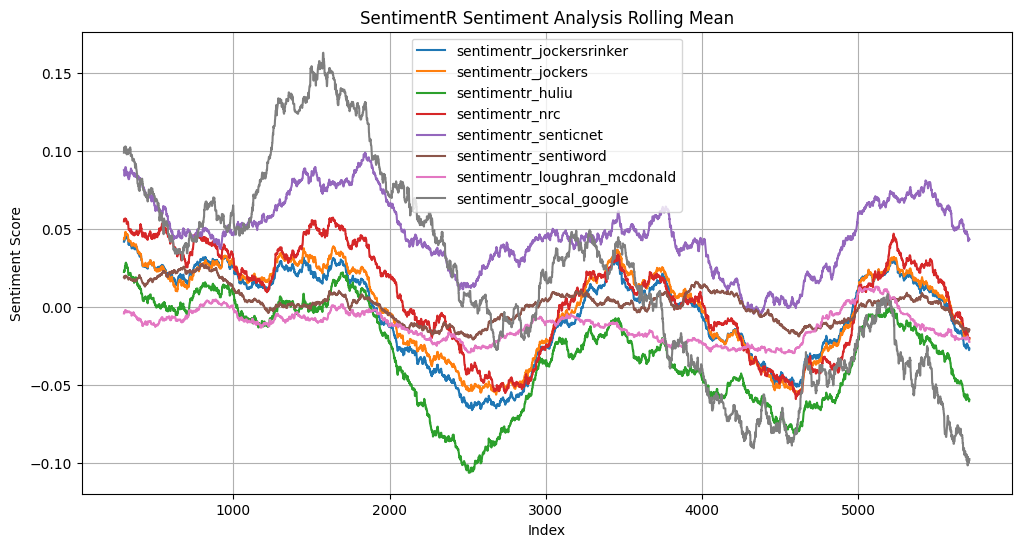

In [ ]:
# Generate the plot properly
win_per = 0.1
win_size = int(win_per * sentimentr_df.shape[0])

# Create a new figure
plt.figure()

# Plot the rolling mean sentiment
sentimentr_model_ls = [
    'sentimentr_jockersrinker',
    'sentimentr_jockers',
    'sentimentr_huliu',
    'sentimentr_nrc',
    'sentimentr_senticnet',
    'sentimentr_sentiword',
    'sentimentr_loughran_mcdonald',
    'sentimentr_socal_google']
_ = sentimentr_df[sentimentr_model_ls].rolling(win_size, center=True).mean().plot(figsize=(12,6), grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("SentimentR Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_sentimentr_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()


In [ ]:
# Save SyuzhetR Models' Sentiment Time Series

save_df2csv_and_download(sentimentr_df, '_sentimentr_sentiment.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: book_a-brave-new-world_ahuxley_segments_sentimentr_sentiment.csv

STEP 2. Downloading permanent copy of csvfile: book_a-brave-new-world_ahuxley_segments_sentimentr_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Option (2): Statistical ML

* https://towardsdatascience.com/building-a-sentiment-classifier-using-scikit-learn-54c8e7c5d2f0

In [ ]:
# Example: Naive Bayes

# https://www.datacamp.com/tutorial/simplifying-sentiment-analysis-python

In [ ]:
# Example: SVM

# https://www.kaggle.com/code/bansodesandeep/sentiment-analysis-support-vector-machine

## Option (3): Connectionist: Transformers

**WARNING:** This takes a LONG TIME to run to completion (~45mins).

Accelerate Large Models:

* https://ponder.io/faster-hugging-face-with-modin/ ***

* https://huggingface.co/blog/accelerate-large-models

* (Moden) https://github.com/modin-project/modin
* (Moden+HF) https://github.com/ponder-org/ponder-blog/blob/main/Modin%20%2B%20Hugging%20Face%20Tutorial.ipynb

* https://heartbeat.comet.ml/optimizing-a-huggingface-transformer-model-for-toxic-speech-detection-6d59e66f615a

In [ ]:
!pip install -q transformers

In [ ]:
!pip install sentencepiece

In [ ]:
from transformers import pipeline

from transformers import AutoTokenizer, AutoModelWithLMHead  # T5Base 50k
from transformers import AutoModelForSequenceClassification, Trainer
from transformers import AutoModelForSeq2SeqLM, AutoModelWithLMHead

from transformers import BertTokenizer, BertForSequenceClassification

import sentencepiece

In [ ]:
# Test Dataset: List of TestSentiment Strings

test_lines_ls = [
    "I love you.",
    "You hate me.",
    "I'm not sure if I hate you, but I certainly don't care for your attitude young man!"
]

In [ ]:
# Create class for data preparation

class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

### HF: DistilBERT Finetuned (sst2en)

distilbert-base-uncased-finetuned-sst-2-english

* https://huggingface.co/docs/transformers/task_summary

In [ ]:
# Load tokenizer and model, create trainer

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Create list of texts (can be imported from .csv, .xls etc.)

# Test
line_ls = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']

# Novel Lines
line_ls = sentiment_df['line'].to_list()

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
# import wandb

# wandb.init() # wandb.log()

In [ ]:
%%time

# NOTE: 0m40s 02:49EST on 28Oct2022 Colab Pro (The Idiot)


# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 31.1 s, sys: 212 ms, total: 31.3 s
Wall time: 46.9 s


In [ ]:
type(predictions)

transformers.trainer_utils.PredictionOutput

In [ ]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
line_no_ls = list(range(len(sentiment_ls)))

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
distilbert_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','distilbert','label','score'])
distilbert_df.head()

,line_no,line,distilbert,label,score
0,0,chapter i a squat grey building of only thirty...,0,NEGATIVE,0.999467
1,1,"over the main entrance the words, =central lon...",1,POSITIVE,0.942054
2,2,the enormous room on the ground-floor faced to...,1,POSITIVE,0.974001
3,3,"cold for all the summer beyond the panes, for ...",0,NEGATIVE,0.952085
4,4,wintriness responded to wintriness.,0,NEGATIVE,0.979881


In [ ]:
distilbert_df['label'].unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'DistilBERT Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_a-brave-new-world_ahuxley_segments_distilbert_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_a-brave-new-world_ahuxley_segments_distilbert_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

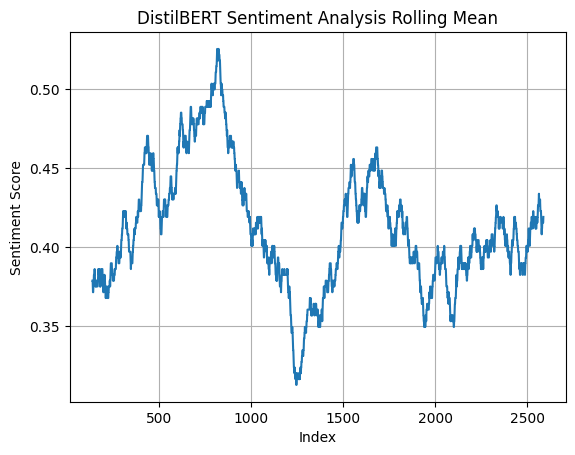

In [ ]:
win_per = 0.1
win_size = int(win_per * distilbert_df.shape[0])

# Create a new figure
plt.figure()

_ = distilbert_df['distilbert'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("DistilBERT Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_distilbert_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [ ]:
# Save Model Sentiment Time Series

save_df2csv_and_download(distilbert_df, '_distilbert_sentiment.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: book_a-brave-new-world_ahuxley_segments_distilbert_sentiment.csv

STEP 2. Downloading permanent copy of csvfile: book_a-brave-new-world_ahuxley_segments_distilbert_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### HF: MultiBERT NLPTown

nlptown/bert-base-multilingual-uncased-sentiment

* https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment?text=I+like+you.+I+love+you

In [ ]:
# Load tokenizer and model, create trainer

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Create list of texts (can be imported from .csv, .xls etc.)

# Test
# line_ls = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']

# Novel Lines
line_ls = sentiment_df['line'].to_list()

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
%%time

# NOTE:  4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#        1m28s 01:24EST on 28Oct2022 Colab Pro (The Idiot)
#        1m27s 02:42EST on 28Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 1min 14s, sys: 250 ms, total: 1min 14s
Wall time: 1min 18s


In [ ]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
line_no_ls = list(range(len(sentiment_ls)))

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
nlptown_df = pd.DataFrame(list(zip(line_no_ls,line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','nlptown','label','score'])
nlptown_df.head()

,line_no,line,nlptown,label,score
0,0,chapter i a squat grey building of only thirty...,1,2 stars,0.280972
1,1,"over the main entrance the words, =central lon...",4,5 stars,0.359854
2,2,the enormous room on the ground-floor faced to...,2,3 stars,0.260968
3,3,"cold for all the summer beyond the panes, for ...",1,2 stars,0.363367
4,4,wintriness responded to wintriness.,4,5 stars,0.440062


In [ ]:
nlptown_df.shape

(2723, 5)

In [ ]:
nlptown_df['label'].unique()

array(['2 stars', '5 stars', '3 stars', '1 star', '4 stars'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'NLPTown Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_a-brave-new-world_ahuxley_segments_nlptown_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_a-brave-new-world_ahuxley_segments_nlptown_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

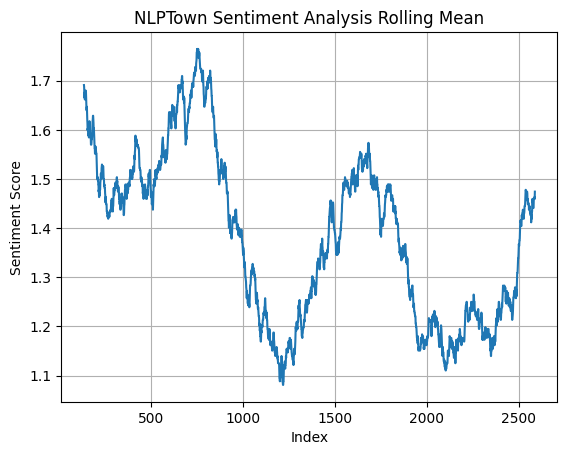

In [ ]:
win_per = 0.1
win_size = int(win_per * nlptown_df.shape[0])

# Create a new figure
plt.figure()

_ = nlptown_df['nlptown'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("NLPTown Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_nlptown_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [ ]:
# Save Model Sentiment Time Series

save_df2csv_and_download(nlptown_df, '_nlptown_sentiment.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: book_a-brave-new-world_ahuxley_segments_nlptown_sentiment.csv

STEP 2. Downloading permanent copy of csvfile: book_a-brave-new-world_ahuxley_segments_nlptown_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### HF: RoBERTa Finetuned (en)

siebert/sentiment-roberta-large-english

* https://colab.research.google.com/github/chrsiebert/sentiment-roberta-large-english/blob/main/sentiment_roberta_prediction_example.ipynb

In [ ]:
# Load tokenizer and model, create trainer

model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Create list of texts (can be imported from .csv, .xls etc.)

# Test
line_ls = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']

# Novel Lines
line_ls = sentiment_df['line'].to_list()

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
%%time

# NOTE: 4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#       4m18s 02:27EST on 27Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

CPU times: user 4min 8s, sys: 538 ms, total: 4min 8s
Wall time: 4min 10s


In [ ]:
type(predictions)

transformers.trainer_utils.PredictionOutput

In [ ]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
line_no_ls = list(range(len(sentiment_ls)))

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
roberta15lg_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','roberta15lg','label','score'])
roberta15lg_df.head()

,line_no,line,roberta15lg,label,score
0,0,chapter i a squat grey building of only thirty...,0,NEGATIVE,0.998993
1,1,"over the main entrance the words, =central lon...",1,POSITIVE,0.996306
2,2,the enormous room on the ground-floor faced to...,1,POSITIVE,0.998072
3,3,"cold for all the summer beyond the panes, for ...",0,NEGATIVE,0.998090
4,4,wintriness responded to wintriness.,1,POSITIVE,0.997487


In [ ]:
roberta15lg_df['label'].unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'RoBERTa Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_a-brave-new-world_ahuxley_segments_roberta15lg_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_a-brave-new-world_ahuxley_segments_roberta15lg_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

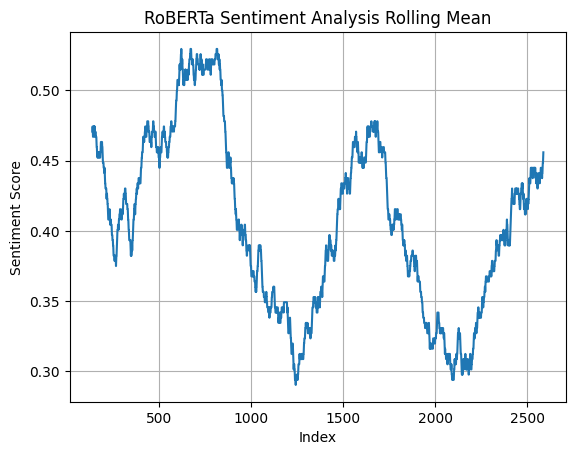

In [ ]:
win_per = 0.1
win_size = int(win_per * roberta15lg_df.shape[0])

# Create a new figure
plt.figure()

_ = roberta15lg_df['roberta15lg'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("RoBERTa Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_roberta15lg_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [ ]:
# Save Model Sentiment Time Series

save_df2csv_and_download(roberta15lg_df, '_roberta15lg_sentiment.csv', nodate=True)

STEP 1. Saving DataFrame to temporary VM file: book_a-brave-new-world_ahuxley_segments_roberta15lg_sentiment.csv

STEP 2. Downloading permanent copy of csvfile: book_a-brave-new-world_ahuxley_segments_roberta15lg_sentiment.csv



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **[SKIP to Plot Section]** Option (4): LLM Transformers

**WARNING:** This takes a LONG TIME to run to completion (~45mins).

Accelerate Large Models:

* https://ponder.io/faster-hugging-face-with-modin/ ***

* https://huggingface.co/blog/accelerate-large-models

* (Moden) https://github.com/modin-project/modin
* (Moden+HF) https://github.com/ponder-org/ponder-blog/blob/main/Modin%20%2B%20Hugging%20Face%20Tutorial.ipynb

* https://heartbeat.comet.ml/optimizing-a-huggingface-transformer-model-for-toxic-speech-detection-6d59e66f615a

In [ ]:
# NOTE: Large language models (LLM) like these do not fit into the typical 24GB VRAM of T4 GPUs
#       This will only work on larger GPUs like 48GB GPUs with perhaps quantized version so skip for now



def get_llm_sentiment(model_name, lines_ls, batch_size=10):
    """
    Get sentiment scores for a list of sentences using a Hugging Face LLM.

    Parameters:
    model_name (str): Name of Hugging Face model
    lines_ls (list): List of text sentences to analyze
    batch_size (int): Number of lines to process at once to manage memory

    Returns:
    list: List of sentiment scores between -1.0 and 1.0
    """
    from transformers import AutoTokenizer, AutoModelForCausalLM
    import torch
    from tqdm import tqdm
    import numpy as np

    # Initialize model and tokenizer
    print(f"Loading {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    sentiment_ls = []

    # Process in batches
    for i in tqdm(range(0, len(lines_ls), batch_size), desc="Analyzing sentiment"):
        batch = lines_ls[i:i + batch_size]
        batch_sentiments = []

        for text in batch:
            # Skip empty or whitespace-only lines
            if not text.strip():
                batch_sentiments.append(0.0)
                continue

            # Create prompt
            prompt = f"""Analyze the sentiment of the following text and return only a single float number between -1.0 (most negative) and 1.0 (most positive) representing the sentiment polarity. Return only the number.

Text: "{text}"

Sentiment score:"""

            # Tokenize and generate
            inputs = tokenizer(prompt, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            try:
                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=20,
                        num_return_sequences=1,
                        temperature=0.1,  # Low temperature for more consistent outputs
                        pad_token_id=tokenizer.eos_token_id
                    )

                # Decode output
                response = tokenizer.decode(outputs[0], skip_special_tokens=True)

                # Extract just the score from response
                response = response.split("Sentiment score:")[-1].strip()

                # Try to convert to float
                try:
                    score = float(response)
                    # Ensure score is between -1 and 1
                    score = max(min(score, 1.0), -1.0)
                except ValueError:
                    # If conversion fails, use fallback scoring method
                    if any(word in response.lower() for word in ['positive', 'good', 'excellent']):
                        score = 0.5
                    elif any(word in response.lower() for word in ['negative', 'bad', 'poor']):
                        score = -0.5
                    else:
                        score = 0.0

                batch_sentiments.append(score)

            except Exception as e:
                print(f"Error processing text: {text[:50]}... Error: {str(e)}")
                batch_sentiments.append(0.0)

        sentiment_ls.extend(batch_sentiments)

        # Clear GPU memory
        if device.type == "cuda":
            torch.cuda.empty_cache()

    # Clean up
    del model
    del tokenizer
    if device.type == "cuda":
        torch.cuda.empty_cache()

    return sentiment_ls



### Mistral 7B v0.1

In [ ]:
"""
# Example usage:

model_name = "mistralai/Mistral-7B-Instruct-v0.1"
lines = [
    "I absolutely love this beautiful day!",
    "This is the worst experience ever.",
    "The weather is quite nice today."
]
sentiment_scores = get_llm_sentiment(model_name, lines)
for line, score in zip(lines, sentiment_scores):
    print(f"Text: {line}\nSentiment: {score}\n")
""";

### NOTE: T5 vs BERT Architecture Differences

The reason why models like **RoBERTa** and **DistilBERT** work in your notebook but **T5** does not likely comes down to the fundamental differences in architecture and requirements between these models. Here's a detailed explanation:

### 1. **Model Architecture Differences**:
   - **RoBERTa** and **DistilBERT** are based on the **BERT** architecture, which is designed primarily for tasks like classification, token classification, or sequence labeling. These models are simpler in terms of memory usage and computational requirements compared to T5.
   - **T5 (Text-To-Text Transfer Transformer)** is an encoder-decoder model, which means it uses two parts: an encoder and a decoder. This setup generally requires more GPU memory and computing power, especially when fine-tuned for complex tasks like text generation.

### 2. **Resource Requirements**:
   - **T5** models, especially when fine-tuned for specific tasks like the `mrm8488/t5-base-finetuned-imdb-sentiment` model, tend to be more resource-intensive because they process input and output sequences. The GPU memory requirements for T5 can be significantly higher than those for models like RoBERTa or DistilBERT.
   - **RoBERTa** and **DistilBERT** are lighter and less resource-hungry since they are encoder-only models designed for understanding text rather than generating it.

### 3. **CUDA and Model Compatibility**:
   - **RoBERTa** and **DistilBERT** models are generally more stable across various CUDA and PyTorch versions due to their simpler architecture.
   - The **T5** model, particularly the fine-tuned version you are using, might be more sensitive to version mismatches between PyTorch, CUDA, and the `transformers` library. Even a slight discrepancy in CUDA versions (e.g., CUDA 12 vs. CUDA 11.8) might lead to errors for T5 but not for simpler models.

### 4. **Model Implementation Differences in `transformers`**:
   - The way the **Hugging Face `transformers`** library handles different model architectures can also lead to discrepancies. The BERT architecture (which RoBERTa and DistilBERT are based on) has been tested extensively across various environments, so it's usually stable and less prone to environment-related issues.
   - T5, with its encoder-decoder structure, might have implementation aspects that are more sensitive to CUDA version or hardware settings, particularly when trying to utilize the GPU.

### Potential Solutions to Make T5 Work:
1. **Reduce Model Size**:
   - If possible, try a smaller version of T5, such as `t5-small` or `t5-base` (without fine-tuning) to test if this is a memory issue:

     ```python
     from transformers import pipeline

     pipe = pipeline("text2text-generation", model="t5-small", device=0)
     ```

2. **Use CPU as a Debugging Step**:
   - Test running T5 on the CPU (`device=-1`) to confirm if the issue is GPU-specific:

     ```python
     pipe = pipeline("text2text-generation", model="mrm8488/t5-base-finetuned-imdb-sentiment", device=-1)
     ```

3. **Check GPU Memory**:
   - Monitor GPU memory usage using `nvidia-smi` to see if the GPU runs out of memory when loading the T5 model.

     ```bash
     !nvidia-smi
     ```

4. **Try Different Versions of the Model**:
   - Test other fine-tuned models or the base `t5-base` model to determine if the issue is specific to the fine-tuning:

     ```python
     pipe = pipeline("text2text-generation", model="t5-base", device=0)
     ```

5. **Use a Different CUDA Version**:
   - As mentioned previously, trying a different version of CUDA (like CUDA 11.8) may resolve compatibility issues specific to the T5 model.

By understanding the architecture and resource demands of T5, we can better pinpoint why it may be failing when other models succeed. Let me know if any of these steps help resolve the issue!

### NOTE: T5 Fix (vs BERT)

Based on the versions you provided:
- **Transformers**: 4.44.2
- **Torch**: 2.5.0+cu121

These versions may not be fully compatible, especially since Torch 2.5.0 is quite advanced and may not have full support in Transformers 4.44.2. Torch 2.5.0+cu121 is built for CUDA 12.1, and there could be some incompatibilities with models or the Transformers version that you are using.

### Solutions:

1. **Downgrade PyTorch to a Compatible Version**:
   Try using a version of PyTorch that is compatible with Transformers 4.44.2, such as PyTorch 2.0.1 or similar with CUDA 11.8, which is widely supported in Colab. You can install it using:

   ```python
   !pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2+cu118 -f https://download.pytorch.org/whl/torch_stable.html
   ```

   After installation, restart the runtime and check the versions again to confirm:

   ```python
   import torch
   import transformers

   print(f'Transformers version: {transformers.__version__}')
   print(f'Torch version: {torch.__version__}')
   ```

2. **Reinstall the `transformers` Library**:
   Make sure that `transformers` is up-to-date and compatible with the newly installed PyTorch version:

   ```python
   !pip install transformers --upgrade
   ```

3. **Test the Pipeline Again**:
   After ensuring the correct versions are installed, try running the pipeline again:

   ```python
   from transformers import pipeline

   pipe = pipeline("text2text-generation", model="mrm8488/t5-base-finetuned-imdb-sentiment", device=0)
   ```

This approach should resolve the CUDA compatibility issues. If you encounter any further issues, let me know!

#### (SKIP) HF T5 IMDB

mrm8488/t5-base-finetuned-imdb-sentiment

* https://huggingface.co/mrm8488/t5-base-finetuned-imdb-sentiment

In [ ]:
import torch
torch.cuda.is_available(), torch.cuda.current_device()


(True, 0)

In [ ]:
import transformers
import torch

print(f'Transformers version: {transformers.__version__}')
print(f'Torch version: {torch.__version__}')


Transformers version: 4.44.2
Torch version: 2.5.0+cu121


In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text2text-generation", model="mrm8488/t5-base-finetuned-imdb-sentiment", device=0)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")

def get_sentiment(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

  output = model.generate(input_ids=input_ids,
               max_length=2)

  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label

get_sentiment("I dislike a lot that film")

# Output: 'negative'


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1748: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


'<pad> negative'

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(line_ls,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
%%time

# NOTE: 4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#       4m18s 02:27EST on 27Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

KeyboardInterrupt: 

In [ ]:
type(predictions)

transformers.trainer_utils.PredictionOutput

In [ ]:
# Transform predictions to labels
sentiment_ls = predictions.predictions.argmax(-1)
labels_ls = pd.Series(sentiment_ls).map(model.config.id2label)
scores_ls = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
line_no_ls = list(range(len(sentiment_ls)))

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
roberta15lg_df = pd.DataFrame(list(zip(line_no_ls, line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','roberta15lg','label','score'])
roberta15lg_df.head()

,line_no,line,roberta15lg,label,score
0,0,chapter i a squat grey building of only thirty...,0,LABEL_0,0.998993
1,1,"over the main entrance the words, =central lon...",1,LABEL_1,0.996306
2,2,the enormous room on the ground-floor faced to...,1,LABEL_1,0.998072
3,3,"cold for all the summer beyond the panes, for ...",0,LABEL_0,0.998090
4,4,wintriness responded to wintriness.,1,LABEL_1,0.997487


In [ ]:
roberta15lg_df['label'].unique()

array(['LABEL_0', 'LABEL_1'], dtype=object)

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'RoBERTa Sentiment Analysis Rolling Mean')

Text(0.5, 0, 'Index')

Text(0, 0.5, 'Sentiment Score')

STEP 1. Saving plot to temporary VM file: book_a-brave-new-world_ahuxley_segments_roberta15lg_sentiment_plot.png

STEP 2. Downloading permanent copy of the PNG file: book_a-brave-new-world_ahuxley_segments_roberta15lg_sentiment_plot.png



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

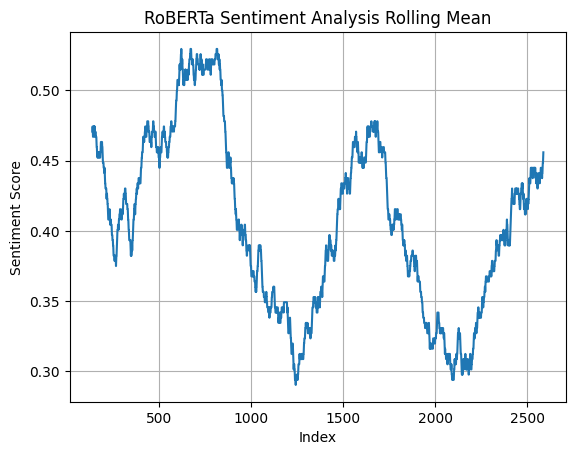

In [ ]:
win_per = 0.1
win_size = int(win_per * roberta15lg_df.shape[0])

# Create a new figure
plt.figure()

_ = roberta15lg_df['roberta15lg'].rolling(win_size, center=True).mean().plot(grid=True)

# Ensure the plot is rendered and saved correctly
plt.title("RoBERTa Sentiment Analysis Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Sentiment Score")

# Save the plot to a PNG file
save_plot2png('_roberta15lg_sentiment_plot.png', nodate=True)

plt.show()

# Close the plot to free up memory
plt.close()

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
t5imdb_df = pd.DataFrame(list(zip(line_no_ls,line_ls,sentiment_ls,labels_ls,scores_ls)), columns=['line_no','line','t5imdb','label','score'])
t5imdb_df.head()

,line_no,line,t5imdb,label,score
0,0,chapter i a squat grey building of only thirty...,0,LABEL_0,0.998993
1,1,"over the main entrance the words, =central lon...",1,LABEL_1,0.996306
2,2,the enormous room on the ground-floor faced to...,1,LABEL_1,0.998072
3,3,"cold for all the summer beyond the panes, for ...",0,LABEL_0,0.998090
4,4,wintriness responded to wintriness.,1,LABEL_1,0.997487


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")

input_ids = tokenizer.encode("Hello, my dog is cute", return_tensors="pt")  # Batch size 1
outputs = model(input_ids=input_ids, decoder_input_ids=input_ids)

last_hidden_states = outputs[0]


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1748: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:
from transformers import T5Tokenizer, T5Model

tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5Model.from_pretrained('t5-small')

input_ids = tokenizer.encode("Hello, my dog is cute", return_tensors="pt")  # Batch size 1
outputs = model(input_ids=input_ids, decoder_input_ids=input_ids)

last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [ ]:
model_name = "t5-small" # "mrm8488/t5-base-finetuned-imdb-sentiment"
tokenizer = AutoModelWithLMHead.from_pretrained(model_name)
model = AutoModelWithLMHead.from_pretrained(model_name)
trainer = Trainer(model=model)

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# Create list of texts (can be imported from .csv, .xls etc.)

# Test
pred_texts = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']

# Novel Lines
pred_texts = line_ls

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(pred_texts) # ,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

AttributeError: 'list' object has no attribute 'size'

In [ ]:
%%time

# NOTE:  4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)
#        1m28s 01:24EST on 28Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

In [ ]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
nlptown_df = pd.DataFrame(list(zip(pred_texts,preds,labels,scores)), columns=['line','pred','label','score'])
nlptown_df.head()

In [ ]:
nlptown_df['label'].unique()

In [ ]:
win_per = 0.1
win_size = int(win_per * nlptown_df.shape[0])

_ = nlptown_df['pred'].rolling(win_size, center=True).mean().plot(grid=True)

In [ ]:
# Save Model Sentiment Time Series

save_df2csv_and_download(nlptown_df, '_nlptown.csv')

In [ ]:


def get_sentiment(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

  output = model.generate(input_ids=input_ids,
               max_length=2)

  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label

get_sentiment("I dislike a lot that film")

# Output: 'negative'


In [ ]:
from transformers import AutoModelForSeq2SeqLM

In [ ]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-base-finetuned-imdb-sentiment")

In [ ]:
# Load tokenizer and model, create trainer

model_name = "mrm8488/t5-base-finetuned-imdb-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
trainer = Trainer(model=model)

In [ ]:
# Create list of texts (can be imported from .csv, .xls etc.)

# Test
pred_texts = ['I like that','That is annoying','This is great!','Wouldn´t recommend it.']

# Novel Lines
pred_texts = line_ls

In [ ]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(pred_texts,truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [ ]:
%%time

# NOTE: 4m00s 23:57EST on 27Oct2022 Colab Pro (The Idiot)

# Run predictions
predictions = trainer.predict(pred_dataset)

In [ ]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
nlptown_df = pd.DataFrame(list(zip(pred_texts,preds,labels,scores)), columns=['text','pred','label','score'])
nlptown_df.head()

In [ ]:
nlptown_df['label'].unique()

In [ ]:
win_per = 0.1
win_size = int(win_per * nlptown_df.shape[0])

_ = nlptown_df['pred'].rolling(win_size, center=True).mean().plot(grid=True)

In [ ]:
# Save VADER Model Sentiment Time Series

save_df2csv_and_download(nlptown_df, '_nlptown.csv')

### HF: T5 Sentiment Span Extraction

mrm8488/t5-base-finetuned-span-sentiment-extraction"

* https://huggingface.co/mrm8488/t5-base-finetuned-imdb-sentiment

In [ ]:
!pip install transformers[sentencepiece]

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

model = "mrm8488/t5-base-finetuned-span-sentiment-extraction"
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelWithLMHead.from_pretrained(model)

In [ ]:


def get_sentiment_span(text):
  input_ids = tokenizer.encode(text, return_tensors="pt", add_special_tokens=True)  # Batch size 1

  generated_ids = model.generate(input_ids=input_ids, num_beams=1, max_length=80).squeeze()

  predicted_span = tokenizer.decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

  return predicted_span

get_sentiment_span("question: negative context: My bike was put on hold...should have known that.... argh total bummer")

# output: 'argh total bummer'

get_sentiment_span("question: positive context: On the monday, so i wont be able to be with you! i love you")

# output: 'i love you'


# Plot

## Dialate SentimentR, Combine, and Plot Together

* VADER
* TextBlob
* SyuzhetR (4)
* DistilBERT
* NLPTown
* RoBERTa15lg

In [ ]:
!ls -altr

total 14956
drwxr-xr-x 4 root root   4096 Oct 29 13:25 .config
drwxr-xr-x 1 root root   4096 Oct 29 13:25 sample_data
drwxr-xr-x 1 root root   4096 Oct 30 20:52 ..
-rw-r--r-- 1 root root 428540 Oct 30 20:59 book_frankenstein_mshelley.txt
-rw-r--r-- 1 root root 418202 Oct 30 21:03 book_frankenstein_mshelley_segments.txt
-rw-r--r-- 1 root root  40821 Oct 30 21:03 book_frankenstein_mshelley_vader_sentiment_plot.png
-rw-r--r-- 1 root root 437608 Oct 30 21:03 book_frankenstein_mshelley_vader_sentiment.csv
-rw-r--r-- 1 root root  46368 Oct 30 21:03 book_frankenstein_mshelley_textblob_sentiment_plot.png
-rw-r--r-- 1 root root 443366 Oct 30 21:03 book_frankenstein_mshelley_textblob_sentiment.csv
-rw-r--r-- 1 root root 125678 Oct 30 21:05 book_frankenstein_mshelley_syzhet_sentiment_plot.png
-rw-r--r-- 1 root root 451135 Oct 30 21:05 book_frankenstein_mshelley_syuzhetr_sentiment.csv
-rw-r--r-- 1 root root 202259 Oct 30 21:05 book_frankenstein_mshelley_sentimentr_sentiment_plot.png
-rw-r--r-- 1 r

In [ ]:
def clean_filenames_with_max_n(substr_del_template=' ({n})'):
    # Regex pattern to match the substring pattern " ({n})" where n is any integer
    pattern = re.compile(r' \((\d+)\)')

    # Dictionary to store filenames with their highest "n" value
    files_to_keep = {}

    # Iterate over all files in the current directory
    for filename in os.listdir('.'):
        match = pattern.search(filename)
        if match:
            # Extract the number and the root filename (without the " (n)" part and the extension)
            n_value = int(match.group(1))
            root_filename = pattern.sub('', filename)
            file_extension = os.path.splitext(filename)[1]
            base_filename = root_filename + file_extension

            # Keep only the file with the highest "n" value for each base filename
            if base_filename not in files_to_keep or n_value > files_to_keep[base_filename][1]:
                files_to_keep[base_filename] = (filename, n_value)

    # Delete files that are not the one with the highest "n" value
    for filename in os.listdir('.'):
        match = pattern.search(filename)
        if match:
            n_value = int(match.group(1))
            root_filename = pattern.sub('', filename)
            file_extension = os.path.splitext(filename)[1]
            base_filename = root_filename + file_extension

            # If the current file is not the one to keep, delete it
            if filename != files_to_keep[base_filename][0]:
                print(f"Deleting file: {filename}")
                os.remove(filename)
            else:
                # Rename the kept file to remove the " (n)" part
                new_name = base_filename
                if filename != new_name:
                    print(f"Renaming {filename} to {new_name}")
                    os.rename(filename, new_name)

# Run the function
clean_filenames_with_max_n()


In [ ]:
!ls -altr

total 10568
drwxr-xr-x 4 root root   4096 Oct 29 13:25 .config
drwxr-xr-x 1 root root   4096 Oct 29 13:25 sample_data
drwxr-xr-x 1 root root   4096 Oct 30 20:52 ..
-rw-r--r-- 1 root root 428540 Oct 30 20:59 book_frankenstein_mshelley.txt
-rw-r--r-- 1 root root 418202 Oct 30 21:03 book_frankenstein_mshelley_segments.txt
-rw-r--r-- 1 root root  40821 Oct 30 21:03 book_frankenstein_mshelley_vader_sentiment_plot.png
-rw-r--r-- 1 root root 437608 Oct 30 21:03 book_frankenstein_mshelley_vader_sentiment.csv
-rw-r--r-- 1 root root  46368 Oct 30 21:03 book_frankenstein_mshelley_textblob_sentiment_plot.png
-rw-r--r-- 1 root root 443366 Oct 30 21:03 book_frankenstein_mshelley_textblob_sentiment.csv
-rw-r--r-- 1 root root 125678 Oct 30 21:05 book_frankenstein_mshelley_syzhet_sentiment_plot.png
-rw-r--r-- 1 root root 451135 Oct 30 21:05 book_frankenstein_mshelley_syuzhetr_sentiment.csv
-rw-r--r-- 1 root root 202259 Oct 30 21:05 book_frankenstein_mshelley_sentimentr_sentiment_plot.png
-rw-r--r-- 1 r

In [ ]:
def make_csv_list(filename_root):
    # List of possible model names
    model_ls = ['vader', 'textblob', 'syuzhetr', 'sentimentr', 'distilbert', 'nlptown', 'roberta15lg']

    # Remove the file extension and extract the title_author part
    filename_without_ext = os.path.splitext(filename_root)[0]
    parts = filename_without_ext.split('_')
    title_author = '_'.join(parts[1:3])  # Get both parts of title_author (e.g., "the-great-gatsby_fscottfitzgerald")

    # Initialize an empty list to hold the found CSV files
    csv_list = []

    # Debugging information
    print(f"Looking for files with title_author: {title_author}")

    # Iterate through each model name and construct the expected filename
    for model_name in model_ls:
        # Construct the filename based on the pattern
        csv_filename = f'book_{title_author}_{model_name}_sentiment.csv'

        # Check if the file exists in the current directory
        if os.path.isfile(csv_filename):
            csv_list.append(csv_filename)
        else:
            print(f"File not found: {csv_filename}")

    return csv_list




In [ ]:
!ls

book_frankenstein_mshelley_distilbert_sentiment.csv
book_frankenstein_mshelley_distilbert_sentiment_plot.png
book_frankenstein_mshelley_nlptown_sentiment.csv
book_frankenstein_mshelley_nlptown_sentiment_plot.png
book_frankenstein_mshelley_roberta15lg_sentiment.csv
book_frankenstein_mshelley_roberta15lg_sentiment_plot.png
book_frankenstein_mshelley_segments.txt
book_frankenstein_mshelley_sentimentr_sentiment.csv
book_frankenstein_mshelley_sentimentr_sentiment_plot.png
book_frankenstein_mshelley_syuzhetr_sentiment.csv
book_frankenstein_mshelley_syzhet_sentiment_plot.png
book_frankenstein_mshelley_textblob_sentiment.csv
book_frankenstein_mshelley_textblob_sentiment_plot.png
book_frankenstein_mshelley.txt
book_frankenstein_mshelley_vader_sentiment.csv
book_frankenstein_mshelley_vader_sentiment_plot.png
book_theodyssey_homer_distilbert_sentiment.csv
book_theodyssey_homer_distilbert_sentiment_plot.png
book_theodyssey_homer_nlptown_sentiment.csv
book_theodyssey_homer_nlptown_sentiment_plot.pn

In [ ]:
!ls -altr book_a-brave* | tail

-rw-r--r-- 1 root root 125118 Oct 30 21:40 book_a-brave-new-world_ahuxley_segments_syzhet_sentiment_plot.png
-rw-r--r-- 1 root root 433727 Oct 30 21:40 book_a-brave-new-world_ahuxley_segments_syuzhetr_sentiment.csv
-rw-r--r-- 1 root root 179703 Oct 30 21:41 book_a-brave-new-world_ahuxley_segments_sentimentr_sentiment_plot.png
-rw-r--r-- 1 root root 581313 Oct 30 21:41 book_a-brave-new-world_ahuxley_segments_sentimentr_sentiment.csv
-rw-r--r-- 1 root root  40262 Oct 30 21:42 book_a-brave-new-world_ahuxley_segments_distilbert_sentiment_plot.png
-rw-r--r-- 1 root root 451463 Oct 30 21:42 book_a-brave-new-world_ahuxley_segments_distilbert_sentiment.csv
-rw-r--r-- 1 root root  42819 Oct 30 21:43 book_a-brave-new-world_ahuxley_segments_nlptown_sentiment_plot.png
-rw-r--r-- 1 root root 448303 Oct 30 21:43 book_a-brave-new-world_ahuxley_segments_nlptown_sentiment.csv
-rw-r--r-- 1 root root 451466 Oct 30 21:47 book_a-brave-new-world_ahuxley_segments_roberta15lg_sentiment.csv
-rw-r--r-- 1 root r

In [ ]:
# NOTE: Your uploaded text files should have 3 parts separated by two '_' underscores
# "book" + "_" + "title-words-separated-by-hyphens" + "_" + "author" (where author is one word with only alphanumeric chars, no hypens or other punctuations)

BOOK_FILENAME_AUTHOR = 'book_animal-farm_gorwell'
BOOK_FILENAME_AUTHOR = 'book_harry-potter-and-the-order-of-the-phoenix_jkrowlings'
BOOK_FILENAME_AUTHOR = 'book_jane-eyre_cbronte'
BOOK_FILENAME_AUTHOR = 'book_frankenstein_mshelley'
BOOK_FILENAME_AUTHOR = 'book_theodyssey_homer'
BOOK_FILENAME_AUTHOR = 'book_a-brave-new-world_ahuxley'

In [ ]:
# Example usage
csv_list = make_csv_list(BOOK_FILENAME_AUTHOR)
print(csv_list)

Looking for files with title_author: a-brave-new-world_ahuxley
File not found: book_a-brave-new-world_ahuxley_vader_sentiment.csv
File not found: book_a-brave-new-world_ahuxley_textblob_sentiment.csv
File not found: book_a-brave-new-world_ahuxley_syuzhetr_sentiment.csv
File not found: book_a-brave-new-world_ahuxley_sentimentr_sentiment.csv
File not found: book_a-brave-new-world_ahuxley_distilbert_sentiment.csv
File not found: book_a-brave-new-world_ahuxley_nlptown_sentiment.csv
File not found: book_a-brave-new-world_ahuxley_roberta15lg_sentiment.csv
[]


In [ ]:
models_sa_ls = make_csv_list(BOOK_FILENAME_AUTHOR)
for amodel in models_sa_ls:
  print(amodel)

Looking for files with title_author: a-brave-new-world_ahuxley
File not found: book_a-brave-new-world_ahuxley_vader_sentiment.csv
File not found: book_a-brave-new-world_ahuxley_textblob_sentiment.csv
File not found: book_a-brave-new-world_ahuxley_syuzhetr_sentiment.csv
File not found: book_a-brave-new-world_ahuxley_sentimentr_sentiment.csv
File not found: book_a-brave-new-world_ahuxley_distilbert_sentiment.csv
File not found: book_a-brave-new-world_ahuxley_nlptown_sentiment.csv
File not found: book_a-brave-new-world_ahuxley_roberta15lg_sentiment.csv


In [ ]:
# models_sa_ls.remove('book_the-great-gatsby_fscottfitzgerald_sentimentr.csv')

In [ ]:
sentimentr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6012 entries, 0 to 6011
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   line_no                       6012 non-null   int64  
 1   sentimentr_jockersrinker      6012 non-null   float64
 2   sentimentr_jockers            6012 non-null   float64
 3   sentimentr_huliu              6012 non-null   float64
 4   sentimentr_nrc                6012 non-null   float64
 5   sentimentr_senticnet          6012 non-null   float64
 6   sentimentr_sentiword          6012 non-null   float64
 7   sentimentr_loughran_mcdonald  6012 non-null   float64
 8   sentimentr_socal_google       6012 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 422.8 KB


In [ ]:
for amodel in models_sa_ls:
  print(f"\n\n{amodel}")
  temp_df = pd.read_csv(amodel)
  print(temp_df.columns)

In [ ]:
sentiment_all_df = pd.read_csv(models_sa_ls[0])  # Start with vader

for i, amodel in enumerate(models_sa_ls[1:]):
    model_name_str = amodel.split('.')[0].split('_')[-1].lower().strip()
    print(f'Model #{i}: {model_name_str}')

    one_model_df = pd.read_csv(amodel)
    print(f' Cols: {one_model_df.columns.to_list()}')

    # Special handling for sentimentr which has different structure
    if 'sentimentr' in model_name_str:
        # Add line_no as index+1 since sentimentr is missing it
        one_model_df['line_no'] = range(1, len(one_model_df) + 1)

    # Remove unnecessary columns
    cols_to_drop = ['line', 'label', 'score']
    for col in cols_to_drop:
        if col in one_model_df.columns:
            one_model_df.drop(columns=[col], inplace=True)

    # Rename sentiment column if it exists
    if 'sentiment' in one_model_df.columns:
        one_model_df.rename(columns={'sentiment': model_name_str}, inplace=True)

    # Merge on line_no
    sentiment_all_df = sentiment_all_df.merge(one_model_df, on='line_no')

Model #0: sentiment
 Cols: ['line_no', 'line', 'sentiment']
Model #1: sentiment
 Cols: ['line_no', 'line', 'syuzhetr_syuzhet', 'syuzhetr_bing', 'syuzhetr_afinn', 'syuzhetr_nrc']
Model #2: sentiment
 Cols: ['line_no', 'sentimentr_jockersrinker', 'sentimentr_jockers', 'sentimentr_huliu', 'sentimentr_nrc', 'sentimentr_senticnet', 'sentimentr_sentiword', 'sentimentr_loughran_mcdonald', 'sentimentr_socal_google']
Model #3: sentiment
 Cols: ['line_no', 'line', 'distilbert', 'label', 'score']
Model #4: sentiment
 Cols: ['line_no', 'line', 'nlptown', 'label', 'score']
Model #5: sentiment
 Cols: ['line_no', 'line', 'roberta15lg', 'label', 'score']


In [ ]:
sentiment_all_df.head()

,line_no,line,sentiment_x,sentiment_y,syuzhetr_syuzhet,syuzhetr_bing,syuzhetr_afinn,syuzhetr_nrc,sentimentr_jockersrinker,sentimentr_jockers,sentimentr_huliu,sentimentr_nrc,sentimentr_senticnet,sentimentr_sentiword,sentimentr_loughran_mcdonald,sentimentr_socal_google,distilbert,nlptown,roberta15lg
0,0,"tell me, muse, of that man, so ready at need, ...",0.7304,0.325,1.30,2,2,0.0,0.062994,0.062994,0.151186,0.000000,0.504331,0.274812,-0.100791,0.929455,1,4,1
1,1,"nay, but even so he saved not his company, tho...",0.5450,0.000,0.60,-1,3,-2.0,-0.534522,-0.534522,-0.267261,-0.534522,-0.176392,0.325725,0.267261,-0.731324,0,1,0
2,2,for through the blindness of their own hearts ...,0.4939,0.600,-2.70,0,-1,-1.0,-0.510252,-0.510252,0.000000,0.047246,0.684541,0.118114,0.000000,0.385210,0,0,0
3,3,"of these things, goddess, daughter of zeus, wh...",0.0000,0.000,0.60,0,0,1.0,0.145521,0.145521,0.000000,0.242536,0.644902,0.025264,0.000000,0.000000,1,4,1
4,4,"now all the rest, as many as fled from sheer d...",-0.2500,0.220,-2.05,-2,-5,0.0,-0.284284,-0.284284,-0.277350,0.000000,0.632497,-0.095339,-0.138675,-0.172749,0,4,1


In [ ]:
sentiment_all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191 entries, 0 to 1190
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   line_no                       1191 non-null   int64  
 1   line                          1191 non-null   object 
 2   sentiment_x                   1191 non-null   float64
 3   sentiment_y                   1191 non-null   float64
 4   syuzhetr_syuzhet              1191 non-null   float64
 5   syuzhetr_bing                 1191 non-null   int64  
 6   syuzhetr_afinn                1191 non-null   int64  
 7   syuzhetr_nrc                  1191 non-null   float64
 8   sentimentr_jockersrinker      1191 non-null   float64
 9   sentimentr_jockers            1191 non-null   float64
 10  sentimentr_huliu              1191 non-null   float64
 11  sentimentr_nrc                1191 non-null   float64
 12  sentimentr_senticnet          1191 non-null   float64
 13  sen

In [ ]:
def plot_all(sentiment_all_df):
   """
   Plot all sentiment columns after z-score normalization, using SMA smoothing.
   Window size is 10% of series length, with 5% edge extrapolation.
   Includes mean of all series in black.

   Parameters:
   sentiment_all_df (pd.DataFrame): DataFrame containing sentiment columns and line_no
   """
   import matplotlib.pyplot as plt
   import seaborn as sns
   from scipy import stats
   import numpy as np
   import pandas as pd

   # Create a copy to avoid modifying the original dataframe
   df = sentiment_all_df.copy()

   # Get all columns except line_no
   sentiment_cols = [col for col in df.columns if col != 'line_no']

   # Convert columns to numeric, dropping any that can't be converted
   numeric_cols = []
   for col in sentiment_cols:
       try:
           df[col] = pd.to_numeric(df[col])
           numeric_cols.append(col)
       except (ValueError, TypeError):
           print(f"Warning: Dropping column '{col}' as it contains non-numeric values")
           continue

   if not numeric_cols:
       raise ValueError("No numeric columns found for plotting")

   # Calculate window size (10% of series length)
   window_size = max(3, int(len(df) * 0.1))
   # Calculate extrapolation size (5% of series length)
   extrap_size = int(len(df) * 0.05)

   # Create figure with appropriate size
   plt.figure(figsize=(15, 8))

   # Store smoothed series for calculating mean
   all_smoothed = []
   base_linewidth = 1.5  # Base line width for individual series

   # Plot each sentiment column after z-normalization and smoothing
   for col in numeric_cols:
       # Z-normalize the column
       z_scores = stats.zscore(df[col], nan_policy='omit')

       # Create series for smoothing
       series = pd.Series(z_scores)

       # Extrapolate edges before smoothing
       start_values = series[:extrap_size].values[::-1]
       end_values = series[-extrap_size:].values[::-1]

       # Create extended series
       extended_series = pd.concat([
           pd.Series(start_values),
           series,
           pd.Series(end_values)
       ])

       # Apply SMA
       smoothed = extended_series.rolling(window=window_size, center=True).mean()

       # Trim back to original size
       smoothed = smoothed[extrap_size:-extrap_size]

       # Store smoothed series for mean calculation
       all_smoothed.append(smoothed)

       # Plot with some transparency for better visibility when lines overlap
       plt.plot(df['line_no'], smoothed, label=col, alpha=0.7, linewidth=base_linewidth)

   # Calculate and plot mean of all series
   mean_series = pd.concat(all_smoothed, axis=1).mean(axis=1)
   plt.plot(df['line_no'], mean_series, label='Mean of All', color='black',
            alpha=0.7, linewidth=base_linewidth*2)

   # Customize the plot
   plt.title(f'Z-normalized Sentiment Analysis Comparison\n(SMA window: {window_size} lines, {extrap_size} lines extrapolated at edges)',
             fontsize=14)
   plt.xlabel('Line Number', fontsize=12)
   plt.ylabel('Z-normalized Sentiment Score', fontsize=12)

   # Add legend with smaller font and outside the plot
   plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
             fontsize=10, borderaxespad=0.)

   # Add grid for better readability
   plt.grid(True, linestyle='--', alpha=0.7)

   # Adjust layout to prevent legend cutoff
   plt.tight_layout()

   # Show the plot
   plt.show()

   # Print basic statistics
   print("\nCorrelation between different sentiment analyses:")
   correlation_matrix = df[numeric_cols].corr()

   # Use seaborn to create a heatmap of correlations
   plt.figure(figsize=(12, 10))
   sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', center=0, fmt='.2f')
   plt.title('Correlation Matrix of Sentiment Analyses', fontsize=14)
   plt.tight_layout()
   plt.show()

   # Print mean absolute differences between normalized scores
   print("\nMean absolute differences between normalized scores:")
   z_scores_df = df[numeric_cols].apply(lambda x: stats.zscore(x, nan_policy='omit'))

   for i, col1 in enumerate(numeric_cols):
       for col2 in numeric_cols[i+1:]:
           mad = abs(z_scores_df[col1] - z_scores_df[col2]).mean()
           print(f"{col1} vs {col2}: {mad:.3f}")

   return df[numeric_cols]  # Return the numeric columns for further analysis if needed

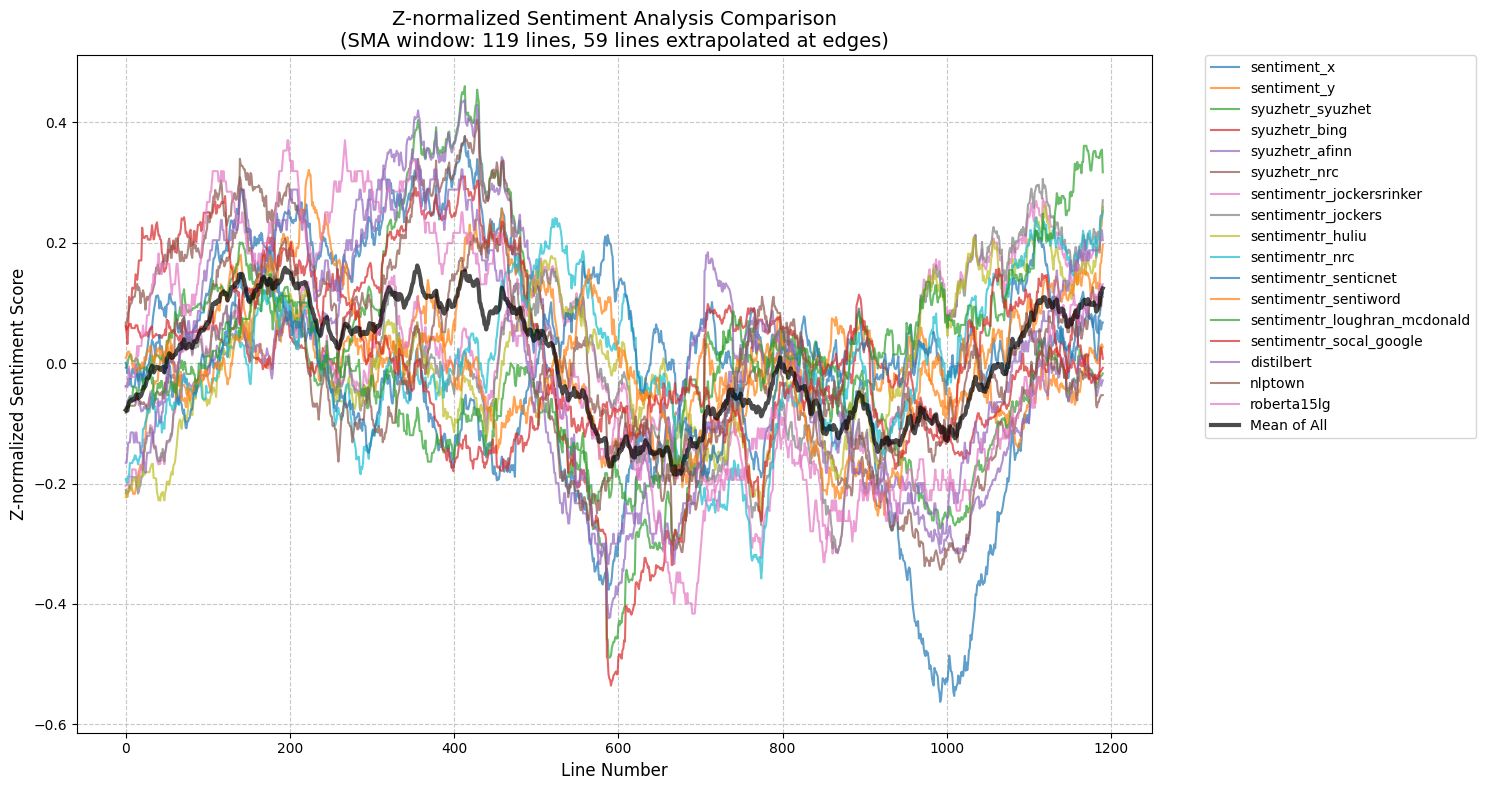


Correlation between different sentiment analyses:


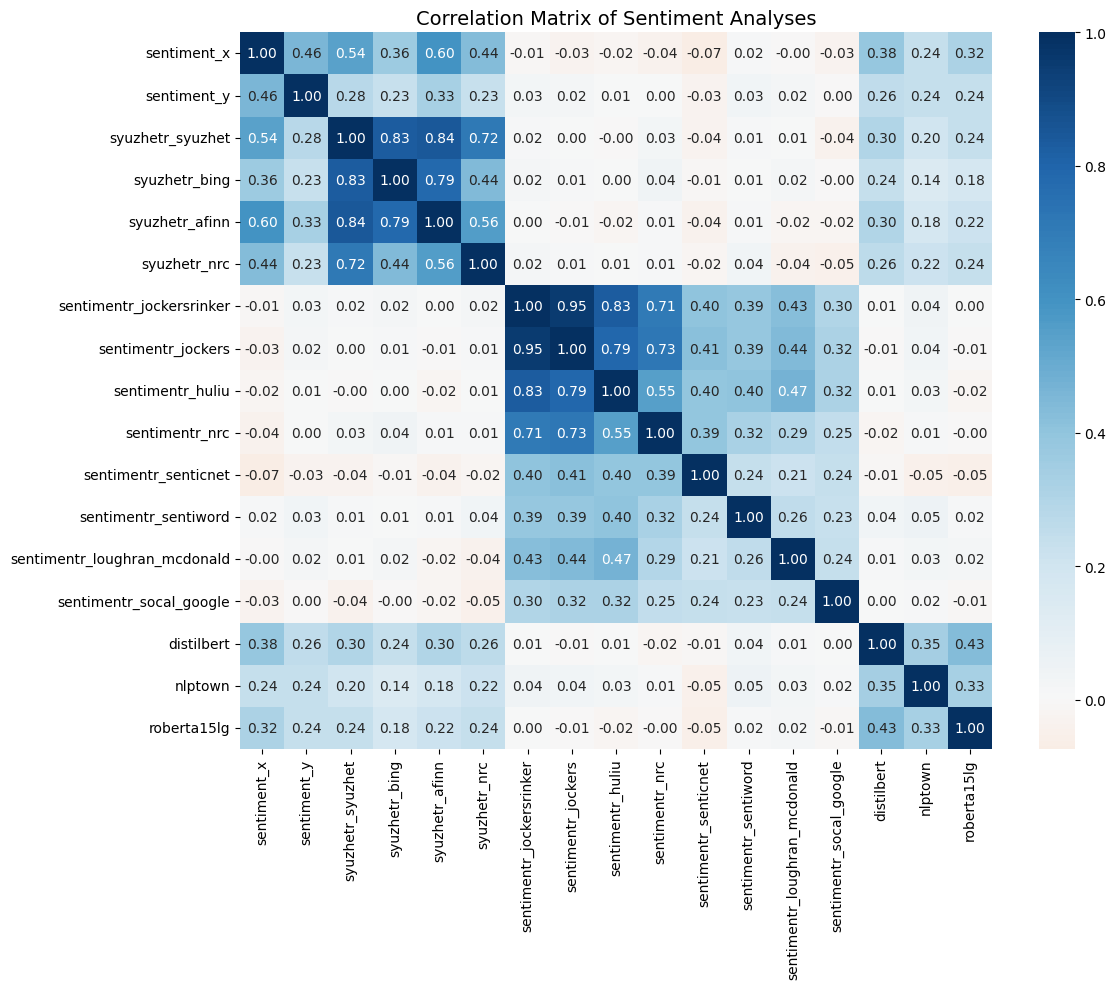


Mean absolute differences between normalized scores:
sentiment_x vs sentiment_y: 0.824
sentiment_x vs syuzhetr_syuzhet: 0.610
sentiment_x vs syuzhetr_bing: 0.672
sentiment_x vs syuzhetr_afinn: 0.569
sentiment_x vs syuzhetr_nrc: 0.744
sentiment_x vs sentimentr_jockersrinker: 1.134
sentiment_x vs sentimentr_jockers: 1.144
sentiment_x vs sentimentr_huliu: 1.137
sentiment_x vs sentimentr_nrc: 1.146
sentiment_x vs sentimentr_senticnet: 1.167
sentiment_x vs sentimentr_sentiword: 1.125
sentiment_x vs sentimentr_loughran_mcdonald: 1.098
sentiment_x vs sentimentr_socal_google: 1.129
sentiment_x vs distilbert: 0.877
sentiment_x vs nlptown: 0.976
sentiment_x vs roberta15lg: 0.929
sentiment_y vs syuzhetr_syuzhet: 0.817
sentiment_y vs syuzhetr_bing: 0.787
sentiment_y vs syuzhetr_afinn: 0.799
sentiment_y vs syuzhetr_nrc: 0.885
sentiment_y vs sentimentr_jockersrinker: 1.073
sentiment_y vs sentimentr_jockers: 1.077
sentiment_y vs sentimentr_huliu: 1.079
sentiment_y vs sentimentr_nrc: 1.081
sentiment_

,sentiment_x,sentiment_y,syuzhetr_syuzhet,syuzhetr_bing,syuzhetr_afinn,syuzhetr_nrc,sentimentr_jockersrinker,sentimentr_jockers,sentimentr_huliu,sentimentr_nrc,sentimentr_senticnet,sentimentr_sentiword,sentimentr_loughran_mcdonald,sentimentr_socal_google,distilbert,nlptown,roberta15lg
0,0.7304,0.325000,1.30,2,2,0.0,0.062994,0.062994,0.151186,0.000000,0.504331,0.274812,-0.100791,0.929455,1,4,1
1,0.5450,0.000000,0.60,-1,3,-2.0,-0.534522,-0.534522,-0.267261,-0.534522,-0.176392,0.325725,0.267261,-0.731324,0,1,0
2,0.4939,0.600000,-2.70,0,-1,-1.0,-0.510252,-0.510252,0.000000,0.047246,0.684541,0.118114,0.000000,0.385210,0,0,0
3,0.0000,0.000000,0.60,0,0,1.0,0.145521,0.145521,0.000000,0.242536,0.644902,0.025264,0.000000,0.000000,1,4,1
4,-0.2500,0.220000,-2.05,-2,-5,0.0,-0.284284,-0.284284,-0.277350,0.000000,0.632497,-0.095339,-0.138675,-0.172749,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1186,-0.8074,-0.100000,-1.25,-3,-4,-2.0,-0.071842,-0.071842,0.000000,0.224507,-0.250903,0.059913,0.000000,0.194881,0,1,0
1187,-0.9455,-0.162000,-6.75,-5,-11,-6.0,0.311769,0.311769,0.000000,0.519615,0.311769,0.129904,0.000000,0.000000,0,0,1
1188,0.6956,0.322222,0.25,1,4,-1.0,0.003714,0.040853,-0.185695,0.111417,0.356906,-0.169447,0.000000,0.000000,1,2,1
1189,-0.3612,0.200000,-1.15,-1,-4,-3.0,0.623274,0.623274,0.480762,0.583782,0.084236,0.389546,0.171701,0.632923,1,4,1


In [ ]:
plot_all(sentiment_all_df)